In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os
from google.colab import files
from google.colab import drive
from PIL import Image



Mounted at /content/drive
Done


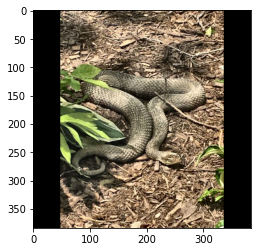

In [2]:
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/5-class.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

image = plt.imread('/content/5-class/preprocessed-cleaned-set/train/class-1/00056e9548477cda7a885bb423cb668c.jpg')
imageShow = plt.imshow(image)

In [3]:
resnet18Model=models.resnet18(pretrained=False)
num_filters = resnet18Model.fc.in_features
num_classes = 5 
resnet18Model.fc = nn.Linear(num_filters,num_classes)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
resnet18Model.load_state_dict(torch.load('/content/5-class-100-epochos-output.pt'))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [4]:
# https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(resnet18Model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18Model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


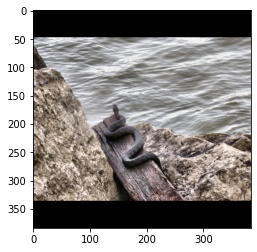

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

image = Image.open(str('/content/5-class/preprocessed-cleaned-set/train/class-1/cff771b0eb30f55c5959d43c322d1752.jpg'))
plt.imshow(image)

image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


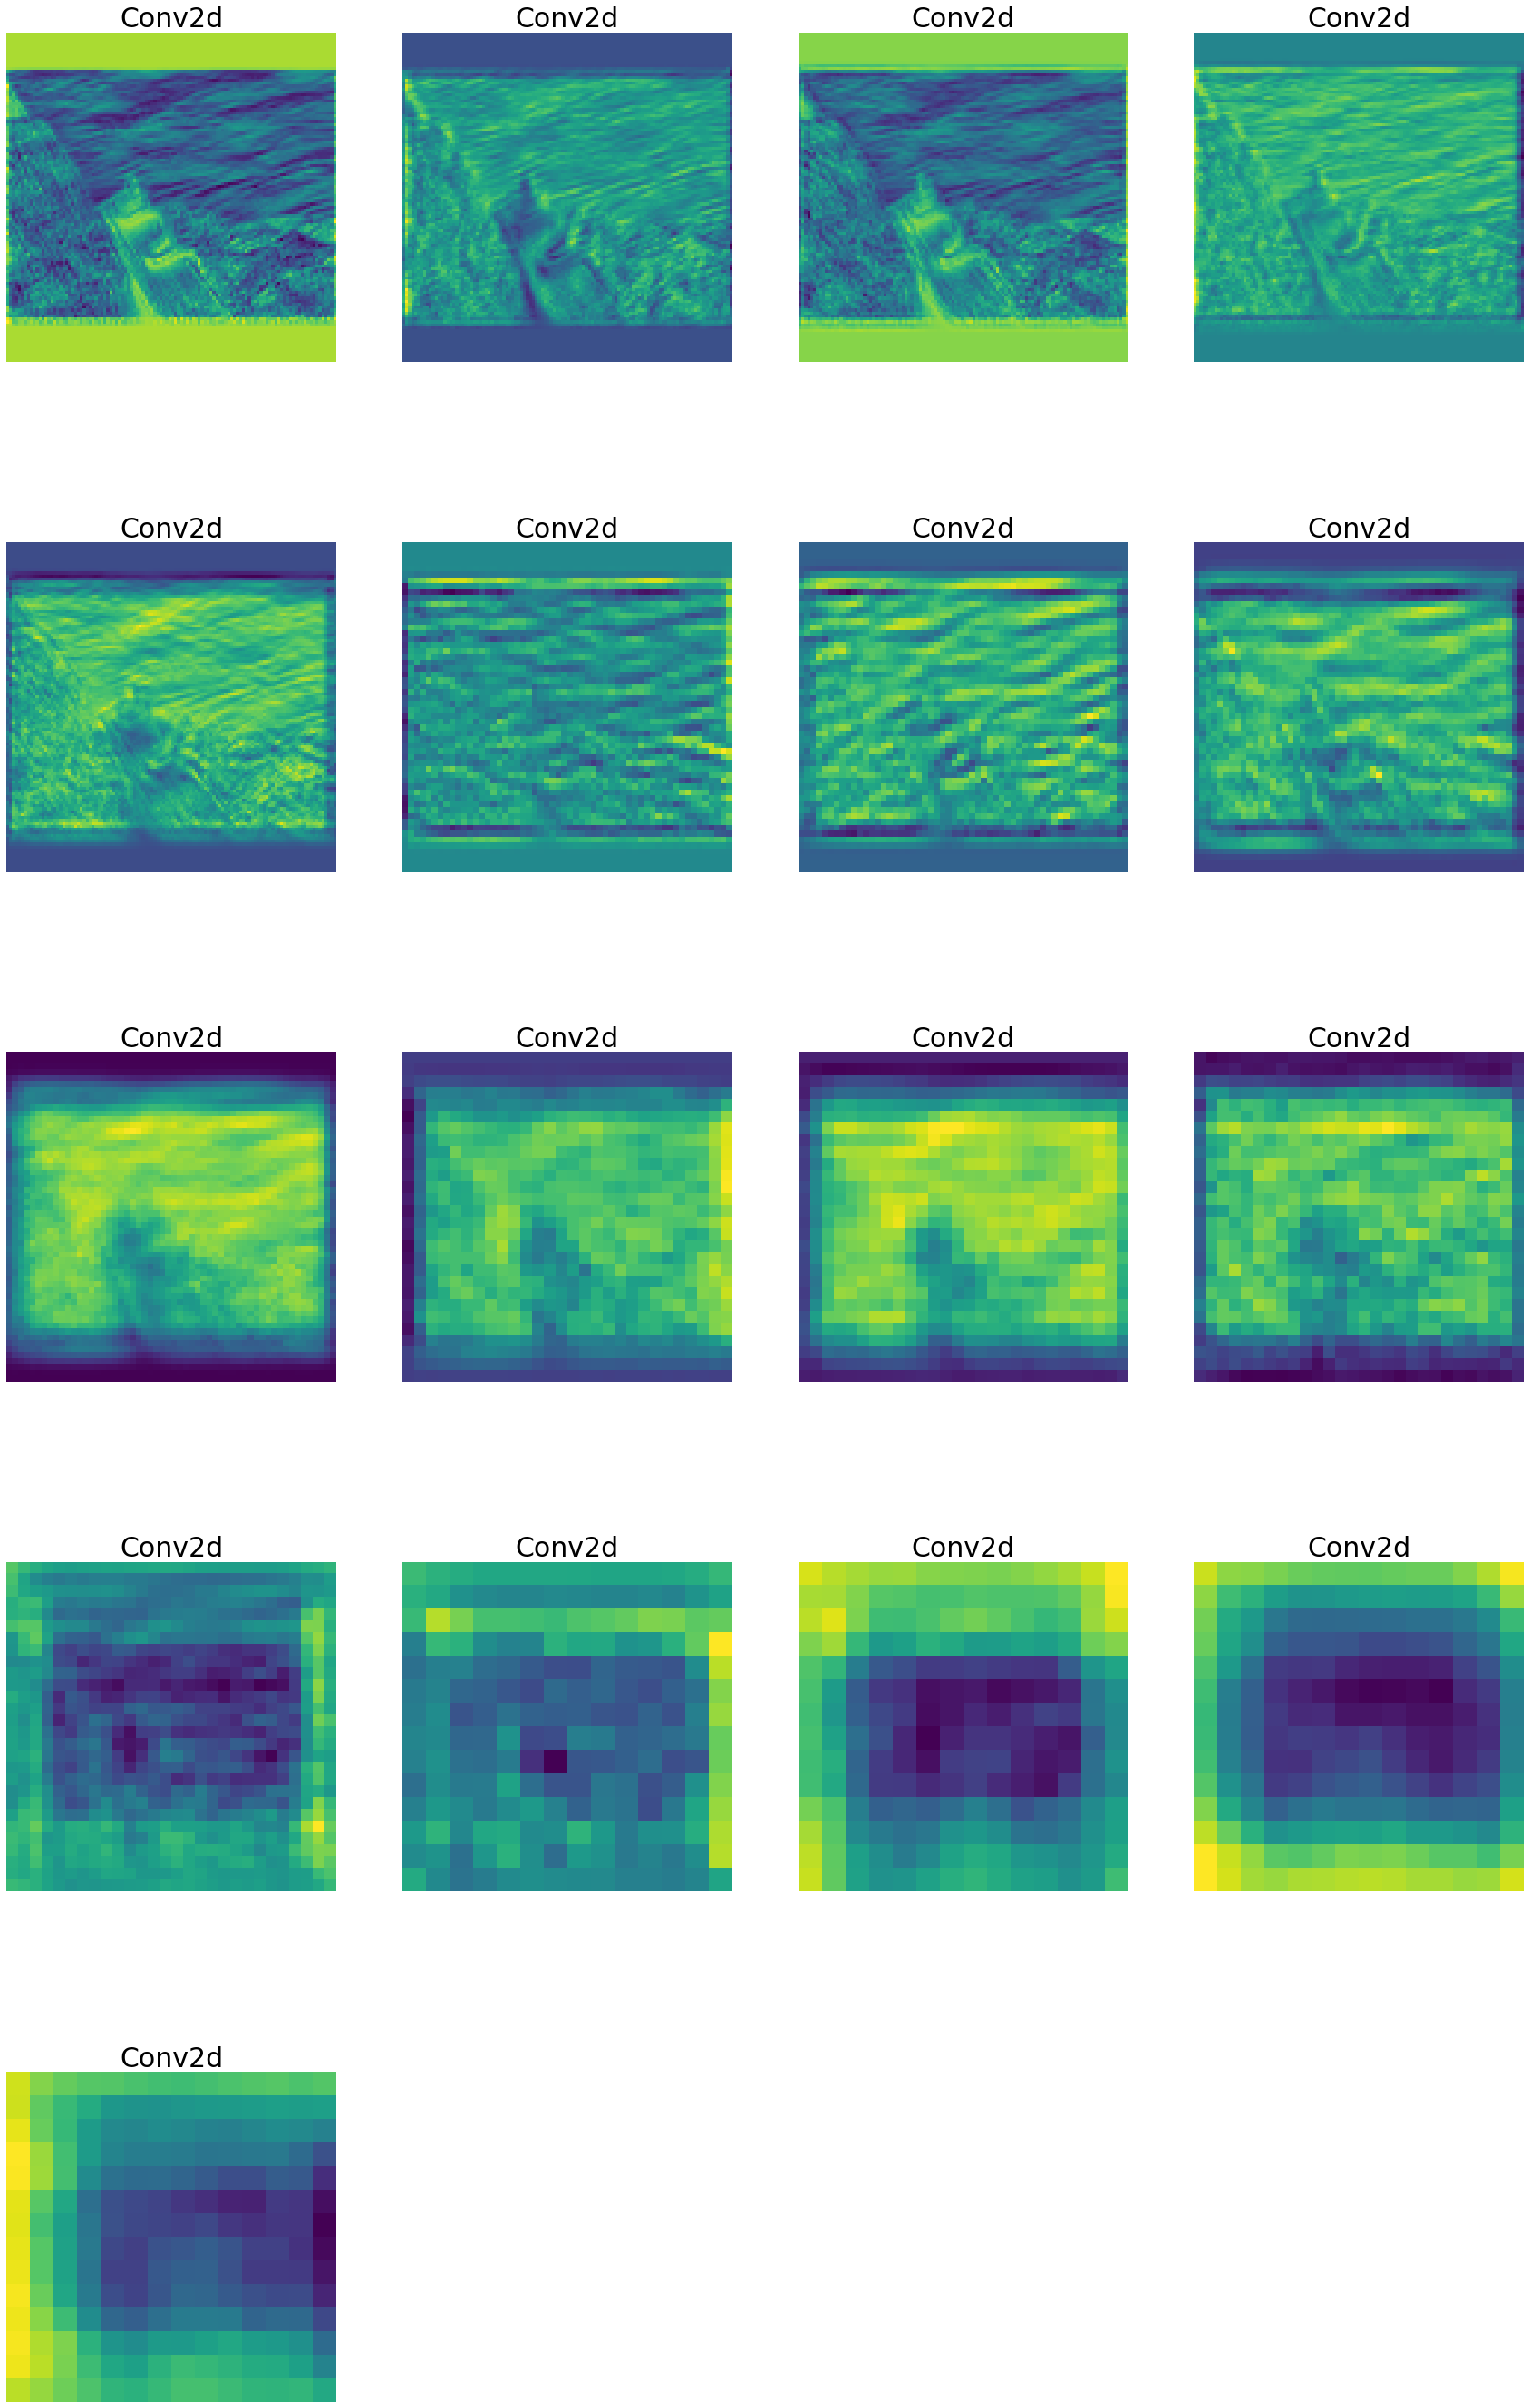

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
import random
seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [8]:

#import this file to train models and pass the  name of the datset
# extract zip files
# load the images and labels based on the dataset requested
# do the pre-processing , batch normalization , flip etc

# Transofrmations for preprocessedSnakeImages dataset
# Reference from https://www.youtube.com/watch?v=z3kB3ISIPAg&list=PL3Dh_99BJkCEhE7Ri8W6aijiEqm3ZoGRq&index=4
training_path = '/content/5-class/preprocessed-cleaned-set/train/'
test_path = '/content/5-class/preprocessed-cleaned-set/test'
val_path = '/content/5-class/preprocessed-cleaned-set/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)
    mean, std = get_mean_std(train_Loader)
    print(mean,std)
    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return data_loader_train,data_loader_test,data_loader_val

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [10]:
train_loader,test_loader,val_loader = transformDS1(32,224)

tensor([0.3461, 0.3217, 0.2852]) tensor([0.2870, 0.2718, 0.2510])


In [ ]:
training_path='/content/15-classes/train'
training_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=32,shuffle=False)

mean, std = get_mean_std(train_Loader)
print(mean,std)

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [ ]:
from tqdm import tqdm
resnet18Model.eval()
labels=[]
image_paths=[]
for batch in tqdm(test_loader, desc='Running the model inference'):
    images = batch[0].to(device)
    labels += batch[1] 
    output = resnet18Model.forward(images)
    with torch.no_grad(): 
      current_outputs = output.detach().cpu().numpy()
      # features = np.concatenate((out, current_outputs))

Running the model inference:   0%|          | 0/55 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18Model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def get_representations(model, iterator):
    model.eval()
    outputs = []
    intermediates = []
    labels = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)
    return outputs, labels


In [ ]:
outputs, labels = get_representations(resnet18Model, train_loader)

In [ ]:
from sklearn import manifold

def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [ ]:
def plot_representations(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


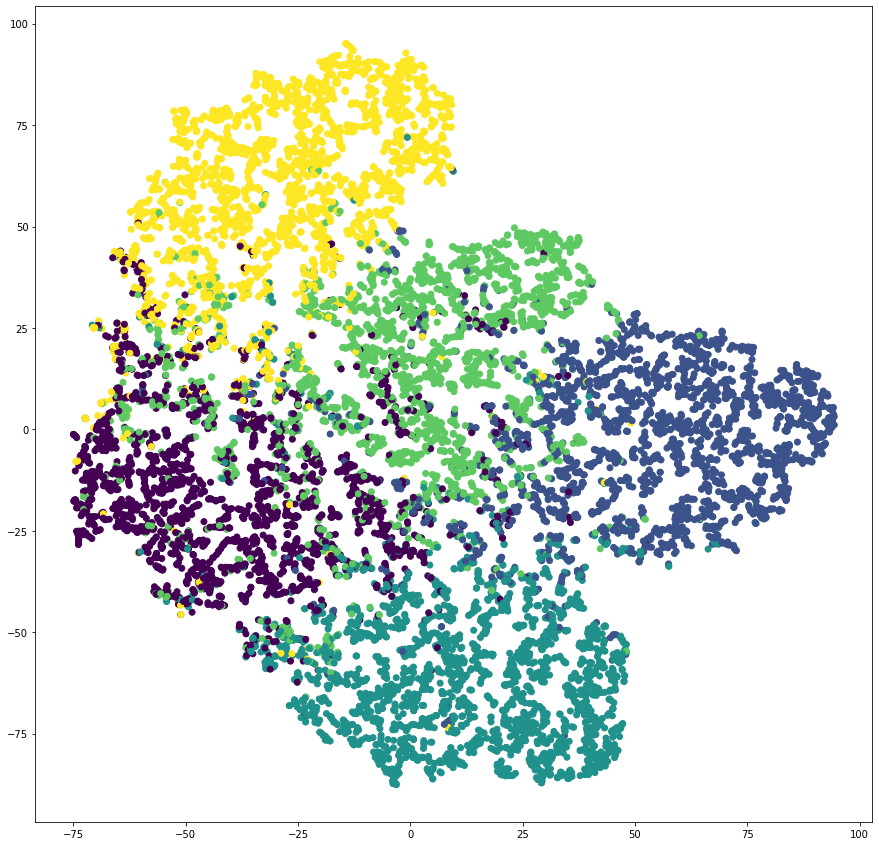

In [ ]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels)

In [ ]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
 
# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
#Make a scatter plot with X_embedded

#TODO: Using Plt.scatter, visualize the transformed data marked with their corresponding label in 2D embedding.

classes=list(set(Y))
plt.figure()

for cl in classes:
    indices = np.where(Y==cl)[0]
    plt.title('T-SNE Visualization')
    plt.scatter(X_embedded[indices,0], X_embedded[indices, 1], label=cl)
    plt.ylabel('Dim_2')
    plt.xlabel('Dim_1')

plt.legend()

In [11]:
!pip install omnixai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 521 kB 5.0 MB/s 
     |████████████████████████████████| 758 kB 69.0 MB/s 
     |████████████████████████████████| 575 kB 58.5 MB/s 
     |████████████████████████████████| 275 kB 71.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6 MB 59.4 MB/s 
     |████████████████████████████████| 132 kB 76.9 MB/s 
  Created wheel for hnswlib: filename=hnswlib-0.6.2-cp38-cp38-linux_x86_64.whl size=1442001 sha256=4de4baabb7b387c7e13daddd1fa11043cc8d7729de6d8a6b6ec0363297f17322
  Stored in directory: /root/.cache/pip/wheels/74/3b/89/4bd924865709f24ac2df457bcca4c0b55a3eb89c5a94ce3ce8
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=3a564ec0c6942d25f09e81e5160ceb839399833de60ae42820df766ceb2c3285
  Stored

In [12]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:29
🔁 Restarting kernel...


In [13]:
!conda install -c conda-forge python-kaleido


Solving environment: | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - python-kaleido


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    expat-2.5.0                |       h27087fc_0         189 KB  conda-forge
    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge
    font-ttf-inconsolata-3.000 |       h77eed37_0          94 KB  conda-forge
    font-ttf-source-code-pro-2.038|       h77eed37_0         684 KB  conda-forge
    font-ttf-ubuntu-0.83       |       hab24e00_0         1.9 MB  conda-forge
    fontconfig-2.14.1          |       hc2a2eb6_0         365 KB  conda-forge
    fonts-conda-forge-1        |                0           4 KB  conda-forge
    freetype-2.12.1            |       hca18f0e_1         611 KB  conda-forge
    kaleido-core-0.2.1         

In [18]:
import plotly.io as pio
pio.renderers.default = "png"
import json
import torch
from torchvision import models, transforms
from PIL import Image as PilImage
from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os
from google.colab import files
from google.colab import drive


In [228]:
# name='train/class-1/000089388ad956f0c33694e569d90fa9.jpg'
# name='val/class-3/07c232e488ee143c7826577e1448a83f.jpg'
# name='train/class-5/0c5c9eb69a76a130ba1f6b03f70e5c83.jpg'
# name="test/class-2/0f2d75322074a87b7d2a18c085df5737.jpg"
name="test/class-4/0d32920975d1d318089d4b17920669e4.jpg"




In [229]:
from omnixai.data.image import Image

img_fpath='/content/5-class/preprocessed-cleaned-set/'+name
im = PilImage.open(img_fpath)
img = Image(data=im)

In [230]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3461, 0.3217, 0.2852], std=[0.2870, 0.2718, 0.2510])
])
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])

In [208]:
def predictScore(model):
    def transform_image():
        my_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.3461, 0.3217, 0.2852], std=[0.2870, 0.2718, 0.2510]
                                                )])
        image = PilImage.open(img_fpath)
        return my_transforms(image).unsqueeze(0)

    model.eval()

    labels=['class-1','class-2','class-3','class-4','class-5']

    def get_prediction():
        tensor = transform_image()
        tensor=tensor.to(device)
        output = model(tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        print(probs.cpu().detach().numpy())
        conf, classes = torch.max(probs, 1)
        return conf.item(), labels[classes.item()],classes.item()

    image_path=img_fpath
    image = plt.imread(image_path)
    plt.imshow(image)

    with open(image_path, 'rb') as f:
    
        conf,y_pre,index=get_prediction()
        print(y_pre, ' at confidence score:{0:.2f}'.format(conf))
        return (y_pre, ' at confidence score:{0:.2f}'.format(conf)),index

In [209]:
def grandCamDisplay(model,label):
  explainer = GradCAM(
    model=model,
    target_layer=model.layer4[-1],
    preprocess_function=preprocess
  )
  # Explain the top label
  print(label)
 
  explanations = explainer.explain(img)
  score,index=predictScore(model)
  print(score)
  explanations.plot(index=0, class_names=['class-1','class-2','class-3','class-4','class-5'])
  # explanations.plotly_plot(index=0, class_names=['class-1','class-2','class-3','class-4','class-5'])
  # print(score)
  # explanations.ipython_plot(index=0, class_names=['class-1','class-2','class-3','class-4','class-5'])
  explanations


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import PIL
import cv2

In [210]:
resnet18Model=models.resnet18(pretrained=False,num_classes = 5)
resnet18Model.load_state_dict(torch.load('/content/5-class-100-epochos-output.pt'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18Model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

resnet18
[[8.6950662e-04 8.4847158e-01 1.2102220e-01 2.9615732e-02 2.0920825e-05]]
class-2  at confidence score:0.85
('class-2', ' at confidence score:0.85')


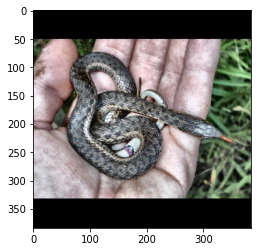

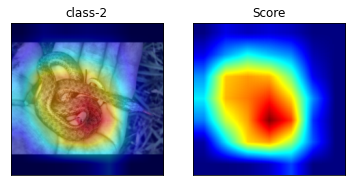

In [211]:
grandCamDisplay(resnet18Model,"resnet18")

In [212]:
mobilenet_v2=models.mobilenet_v2(pretrained=False,num_classes = 5)
mobilenet_v2.load_state_dict(torch.load('/content/mobilenetV2_5_classes-100-epoch.pt'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet_v2.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

mobilenet_v2
[[5.1082560e-04 9.8694032e-01 3.0147508e-04 1.2113830e-02 1.3354140e-04]]
class-2  at confidence score:0.99
('class-2', ' at confidence score:0.99')


[<Figure size 432x288 with 2 Axes>]

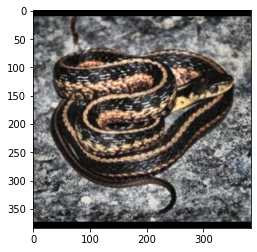

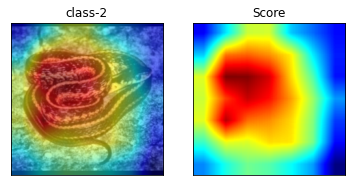

In [219]:
explainer = GradCAM(
  model=mobilenet_v2,
  target_layer=mobilenet_v2.features[-1],
  preprocess_function=preprocess
)
# Explain the top label
print("mobilenet_v2")
score,index=predictScore(mobilenet_v2)
print(score)
explanations = explainer.explain(img)
explanations.plot(index=0, class_names=['class-1','class-2','class-3','class-4','class-5'])

# explanations.ipython_plot(index=0, class_names=[1,2,3,4,5])

In [76]:
from zipfile import ZipFile

file_name = "/content/drive/MyDrive/5-Class-100-epoch.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [231]:
resnet34=models.resnet34(pretrained=False,num_classes = 5)
resnet34.load_state_dict(torch.load('/content/5-Class-100-epoch.pt'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet34.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

resnet34
[[2.2137682e-03 1.6424513e-01 9.7994572e-03 8.2371765e-01 2.3984696e-05]]
class-4  at confidence score:0.82
('class-4', ' at confidence score:0.82')


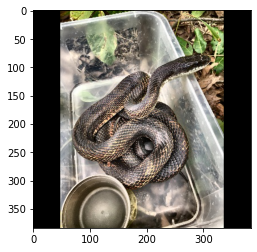

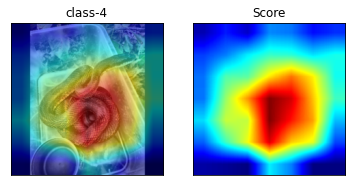

In [232]:
grandCamDisplay(resnet34,"resnet34")